# Genre Prediction Model

In [1]:
import nltk
from nltk.corpus import stopwords
import re
import string
import pandas as pd
import os
import random

## Configuração

In [2]:
# Execute na primeira vez em que usar este notebook
#nltk.download()
MODEL = os.path.join('..','app','model')
TRAINSET = os.path.join('.','train')
WORD_FEATURES = 2500
TEST_RATIO = 0.2 # Size of test set
RANDOM_SEED = 1010011010
N_TREES = 100 # Number of trees for RF
CORES = 3 # How many cores to user for parallel RF (-1 uses all cores)

## Pré processamento

Primeiramente carregamos as letras de música. Cada entrada no **train set** será formada por um verso.

In [3]:
def sample_selection(TR = 0.2, N = 800):
    tr_n = round(N * TR)
    ts_n = N - tr_n
    t1 = [True] * ts_n
    t2 = [False] * tr_n
    t = t1 + t2
        
    train_filter = list()
    for i in range(4):
        random.shuffle(t)
        train_filter = train_filter + t
    return(train_filter)

In [4]:
# Descobre generos que deverão ser utilizados
genres = list()
for file in os.listdir(TRAINSET):
    if file.endswith(".csv"):
        genres.append(file[0:-4])

# Aqui salvaremos o train set sendo gerado a partir dos arquivos texto
raw_corpus = pd.DataFrame()

# Le os arquivos
for g in genres:
    df = pd.read_csv(os.path.join(TRAINSET,'{}.csv'.format(g)))
    df['genero'] = g
    raw_corpus = raw_corpus.append(df)
    
# Dados gerais
n_musicas = len(raw_corpus)
n_generos = len(genres)

# Prepara dataset para ser validado no final
raw_corpus = raw_corpus.reset_index(drop=True)
raw_corpus['idx'] = range(len(raw_corpus))
random.seed('012345')
raw_corpus['inTrain'] = sample_selection(TEST_RATIO)

# Quebra uma estrofe por linha
s = raw_corpus['lyric'].str.split('\n').apply(pd.Series, 1).stack()
s.index = s.index.droplevel(-1) # to line up with df's index
s.name = 'estrofe'
raw_corpus = raw_corpus.join(s)
raw_corpus = raw_corpus[raw_corpus['estrofe'] != ' ']
raw_corpus = raw_corpus.reset_index(drop=True)

print("Corpus contém {} músicas em {}, com um total de {} estrofes".format(n_musicas, n_generos, len(raw_corpus)))

Corpus contém 3200 músicas em 4, com um total de 99380 estrofes


Agora iremos preparar as estrofes com as seguintes ações:

* remover stopwords;
* remover pontuação;
* garantindo que todas as palavras estejam em caixa baixa;
* quebrar cada estrofe em uma lista de palavras

In [5]:
def prepara_estrofes(frase, translator = str.maketrans('', '', string.punctuation)):
    # Remove pontuação
    frase = frase.translate(translator)
    
    # Garante que todas as palavras estão em caixa baixa
    palavras = frase.lower().split()
    
    # Lista de stopwords que usaremos
    stop_w = set(stopwords.words("portuguese"))
    
    # Retorna apenas as palavras que não são stopwords
    palavras_filtradas = [palavra for palavra in palavras if palavra not in stop_w]
    
    # Retorna a estrofe preparada
    return(" ".join(palavras_filtradas))

In [6]:
print(prepara_estrofes('Eu sei que !!! , )vou te amar'))

sei vou amar


Agora iremos aplicar nosso procedimento de preparação no nosso dataset

In [7]:
# Vamos salvas as estrofes preparadas nesta lista
versos_preparados = list()
no_estrofes = len(raw_corpus)

for i in range(0, no_estrofes):
    if( (i+1)%10000 == 0 ):
        print("Verso %d de %d processado" % ( i+1, no_estrofes ) )
    versos_preparados.append( prepara_estrofes(raw_corpus['estrofe'][i]) )
raw_corpus['versos_preparados'] = versos_preparados

Verso 10000 de 99380 processado
Verso 20000 de 99380 processado
Verso 30000 de 99380 processado
Verso 40000 de 99380 processado
Verso 50000 de 99380 processado
Verso 60000 de 99380 processado
Verso 70000 de 99380 processado
Verso 80000 de 99380 processado
Verso 90000 de 99380 processado


## Modelo

Usaremos a abordagem **Bag of Words** para vetorizar nossas estrofes e treinar o modelo

In [8]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score
from sklearn.externals import joblib

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [10]:
%matplotlib inline
def validacao(X, y, classes):
    # TODO Mostrar gráficamente a confusion matrix
    plt.figure()
    plot_confusion_matrix(confusion_matrix(y, X,), classes=classes, title='Confusion matrix')
    plt.show()
    print('Accuracy: {}'.format(accuracy_score(y, X)))
    print('Precision: {}'.format(precision_score(y, X, average='macro')))
    print('Recall: {}'.format(recall_score(y, X, average='macro')))

In [11]:
vetorizador = CountVectorizer(analyzer = "word", tokenizer = None, preprocessor = None,
                              stop_words = None, max_features = WORD_FEATURES)
train_data_features = vetorizador.fit_transform(raw_corpus[raw_corpus.inTrain == True].versos_preparados)
train_data_features = train_data_features.toarray()

In [12]:
X_train, X_test, y_train, y_test = train_test_split(train_data_features, 
                                                    raw_corpus[raw_corpus.inTrain == True].genero,
                                                    test_size=TEST_RATIO, random_state=RANDOM_SEED)

In [13]:
# Inicialzando classificador e treinando modelo
forest = RandomForestClassifier(n_estimators = N_TREES, n_jobs=CORES, verbose=10) 
%time forest = forest.fit( X_train, y_train )
predictions_RF = forest.predict(X_test)

building tree 1 of 100building tree 3 of 100building tree 2 of 100


building tree 4 of 100
building tree 5 of 100


[Parallel(n_jobs=3)]: Done   2 tasks      | elapsed:   22.1s


building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100


[Parallel(n_jobs=3)]: Done   7 tasks      | elapsed:  1.0min


building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100


[Parallel(n_jobs=3)]: Done  12 tasks      | elapsed:  1.4min


building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100


[Parallel(n_jobs=3)]: Done  19 tasks      | elapsed:  2.4min


building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100


[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed:  3.0min


building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100


[Parallel(n_jobs=3)]: Done  35 tasks      | elapsed:  4.2min


building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100


[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:  5.2min


building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100


[Parallel(n_jobs=3)]: Done  55 tasks      | elapsed:  6.4min


building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100


[Parallel(n_jobs=3)]: Done  66 tasks      | elapsed:  7.7min


building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80 of 100
building tree 81 of 100


[Parallel(n_jobs=3)]: Done  79 tasks      | elapsed:  9.1min


building tree 82 of 100
building tree 83 of 100
building tree 84 of 100
building tree 85 of 100
building tree 86 of 100
building tree 87 of 100
building tree 88 of 100
building tree 89 of 100
building tree 90 of 100
building tree 91 of 100
building tree 92 of 100
building tree 93 of 100
building tree 94 of 100


[Parallel(n_jobs=3)]: Done  92 tasks      | elapsed: 11.0min


building tree 95 of 100
building tree 96 of 100
building tree 97 of 100
building tree 98 of 100
building tree 99 of 100
building tree 100 of 100


[Parallel(n_jobs=3)]: Done 100 out of 100 | elapsed: 11.7min finished


CPU times: user 33min 42s, sys: 5.58 s, total: 33min 47s
Wall time: 11min 45s


[Parallel(n_jobs=3)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=3)]: Done   7 tasks      | elapsed:    0.2s
[Parallel(n_jobs=3)]: Done  12 tasks      | elapsed:    0.3s
[Parallel(n_jobs=3)]: Done  19 tasks      | elapsed:    0.4s
[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed:    0.6s
[Parallel(n_jobs=3)]: Done  35 tasks      | elapsed:    0.9s
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    1.0s
[Parallel(n_jobs=3)]: Done  55 tasks      | elapsed:    1.3s
[Parallel(n_jobs=3)]: Done  66 tasks      | elapsed:    1.5s
[Parallel(n_jobs=3)]: Done  79 tasks      | elapsed:    1.8s
[Parallel(n_jobs=3)]: Done  92 tasks      | elapsed:    2.1s
[Parallel(n_jobs=3)]: Done 100 out of 100 | elapsed:    2.2s finished


## Validação

Confusion matrix, without normalization
[[2233  353  307  403]
 [ 597 3825  266  444]
 [ 387  261 2798  307]
 [ 528  515  378 2330]]


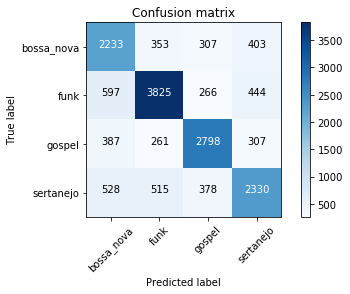

Accuracy: 0.7021089630931459
Precision: 0.6958672288364581
Recall: 0.6973789792858628


In [14]:
# Validando por verso
validacao(predictions_RF, y_test, forest.classes_)

In [15]:
# Validando por música
raw_corpus['pred_verso'] = forest.predict(vetorizador.transform(raw_corpus['versos_preparados']))

[Parallel(n_jobs=3)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=3)]: Done   7 tasks      | elapsed:    0.6s
[Parallel(n_jobs=3)]: Done  12 tasks      | elapsed:    1.1s
[Parallel(n_jobs=3)]: Done  19 tasks      | elapsed:    1.6s
[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed:    2.2s
[Parallel(n_jobs=3)]: Done  35 tasks      | elapsed:    2.9s
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    3.6s
[Parallel(n_jobs=3)]: Done  55 tasks      | elapsed:    4.5s
[Parallel(n_jobs=3)]: Done  66 tasks      | elapsed:    5.5s
[Parallel(n_jobs=3)]: Done  79 tasks      | elapsed:    6.6s
[Parallel(n_jobs=3)]: Done  92 tasks      | elapsed:    7.7s
[Parallel(n_jobs=3)]: Done 100 out of 100 | elapsed:    8.2s finished


In [16]:
from collections import Counter
predicoes_musica = list()
genero_musica = list()
test_music = raw_corpus[raw_corpus.inTrain == False]
for i in test_music['idx'].drop_duplicates():
    df = raw_corpus[raw_corpus.idx == i]
    
    # Encontra classe mais comum
    count = Counter(df['pred_verso'])
    genero_musica.append(df['genero'].unique())
    predicoes_musica.append(count.most_common(1)[0][0])

Confusion matrix, without normalization
[[134   9   3  14]
 [ 14 130   4  12]
 [  7   4 142   7]
 [ 23  31  12  94]]


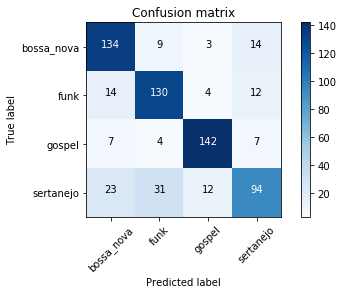

Accuracy: 0.78125
Precision: 0.7805201208750916
Recall: 0.7812499999999999


In [17]:
# Predição por Música
validacao(predicoes_musica,genero_musica, forest.classes_)

In [18]:
# Exportando modelo e vetorizador
joblib.dump(vetorizador, os.path.join(MODEL,'vetorizador.pkl.bz2'))
joblib.dump(forest, os.path.join(MODEL,'modelo.pkl.bz2')) 
joblib.dump(stopwords.words(), os.path.join(MODEL,'stopwords.pkl.bz2')) 

['../app/model/stopwords.pkl.bz2']